In [10]:
import argparse

import os
import csv
import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from unet.model import UNet
from unet.dataset import *
from unet.util import *
from unet.train import train
from unet.evaluate import evaluate
from unet.loss import f1_loss, weighted_loss_and_f1_loss

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torchvision import transforms, datasets

In [11]:
data_dir = "../../../final_data/"

train_transform = transforms.Compose([RandomResizedCrop(ratio=0.3), Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
val_transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=val_transform)
loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=8)

In [12]:
res = np.zeros((1344, 1248), dtype='float')
for batch, data in enumerate(loader_train, 1):
    label_data = np.squeeze(data['label'])
    res += label_data.numpy() / 816
    input_data = np.swapaxes(np.swapaxes(np.squeeze(data['input']), 2, 0), 0, 1)
    input_data = np.round(input_data * 255)
    print(batch)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


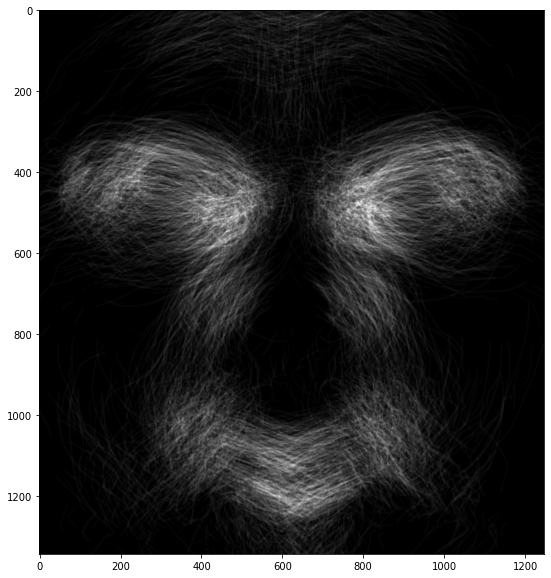

In [13]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(res, cmap='gray')

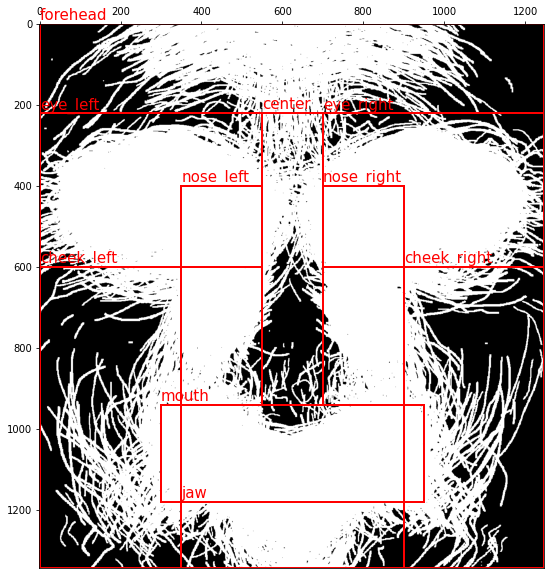

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.tick_top()
plt.imshow(res > 0, cmap='gray')
ax.xaxis.set_label_position('top')

my_dict = {
    'eye_left'    : (0, 550, 220, 600),
    'eye_right'   : (700, 1247, 220, 600),
    'nose_left'   : (350, 550, 400, 940),
    'nose_right'  : (700, 900, 400, 940),
    'mouth'       : (300, 950, 940, 1180),
    'forehead'    : (0, 1247, 0, 220),
    'cheek_right' : (900, 1247, 600, 1343),
    'cheek_left'  : (0, 350, 600, 1343),
    'jaw'         : (350, 900, 1180, 1343),
    'center'      : (550, 700, 220, 940),
}

def my_plot(d):
    for key in d:
        (x1, x2, y1, y2) = d[key]
        plt.text(x1, y1-10, key, color='r', fontsize=15)
        plt.gca().add_patch(Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none'))

my_plot(my_dict)
plt.show()

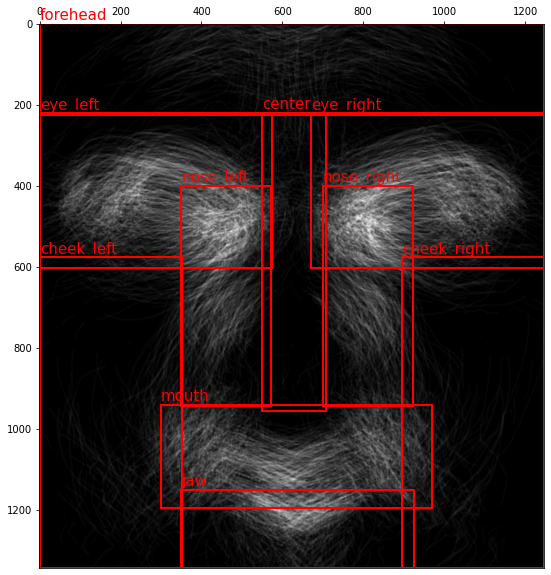

eye_left (0, 575, 220, 603)
eye_right (672, 1247, 220, 603)
nose_left (350, 573, 400, 943)
nose_right (700, 923, 400, 943)
mouth (300, 971, 940, 1195)
forehead (0, 1247, 0, 223)
cheek_right (896, 1247, 576, 1343)
cheek_left (0, 351, 576, 1343)
jaw (350, 925, 1152, 1343)
center (550, 709, 220, 955)


In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.xaxis.tick_top()
plt.imshow(res, cmap='gray')
ax.xaxis.set_label_position('top')

def get_new_dict(d):
    new_dict = {}
    for key in d:
        (x1, x2, y1, y2) = d[key]
        x_size = int((x2 - x1+1)/32+1)*32
        y_size = int((y2 - y1+1)/32+1)*32
        x2 = x1+x_size-1
        y2 = y1+y_size-1
        if x2 > 1247:
            x1 -= (x2-1247)
            x2 = 1247
            if x1 < 0:
                x1 = 0
        if y2 > 1343:
            y1 -= (y2-1343)
            y2 = 1343
            if y1 < 0:
                y1 = 0
        new_dict[key] = (x1, x2, y1, y2)
    return new_dict

new_dict = get_new_dict(my_dict)
my_plot(new_dict)
plt.show()


for key in new_dict:
    print(key, new_dict[key])

In [18]:
def crop(image_folder_path, numpy_folder_path, save_folder_path, x_min, x_max, y_min, y_max):
    print("Processing images ...")
    img_list = os.listdir(image_folder_path)
    img_list = [img_file_name for img_file_name in img_list if img_file_name.endswith(".jpg")]
    for img_file_name in img_list:
        print("Processing " + img_file_name + " ...")
        img = Image.open(image_folder_path + img_file_name).convert('RGB')
        img_npy = np.array(img)
        cropped_img = img_npy[y_min:(y_max+1), x_min:(x_max+1)]
        cropped_img = Image.fromarray(cropped_img.astype(np.uint8))
        cropped_img.save(save_folder_path + img_file_name)

    print("\n--------------------------------------------------------------\n")
    print("Processing images ...")

    label_list = os.listdir(numpy_folder_path)
    label_list = [label_file_name for label_file_name in label_list if label_file_name.endswith(".npy")]
    for label_file_name in label_list:
        print("Processing " + label_file_name + " ...")
        label = np.load(numpy_folder_path + label_file_name)
        cropped_label = label[y_min:(y_max+1), x_min:(x_max+1)]

        filename_without_ext = label_file_name.split(".")[0]
        #cropped_label_img = Image.fromarray((cropped_label * 255).astype(np.uint8))
        #cropped_label_img.save(save_folder_path + "label/jpg/" + filename_without_ext + ".jpg")

        np.save(save_folder_path + label_file_name, cropped_label)

data_dir = "../../../old_data/"
for data in "train/ test/ val/".split():
    for key in new_dict:
        directory = f"../../../split_data/{key}/"+data
        if not os.path.exists(directory):
               os.makedirs(directory)
        (x1, x2, y1, y2) = new_dict[key]
        print(directory)
        crop(data_dir+data, data_dir+data, directory, x1, x2, y1, y2)


0 575 220 603
../../../split_data/eye_left/train/
Processing images ...
Processing 0007_f_20_08_mouth_left_tex.jpg ...
Processing 0015_m_50_04_anger_tex.jpg ...
Processing 0008_f_25_14_sadness_tex.jpg ...
Processing 0006_m_24_08_mouth_left_tex.jpg ...
Processing 0010_f_22_09_mouth_right_tex.jpg ...
Processing 0017_m_31_01_neutral_tex.jpg ...
Processing 0020_m_43_09_mouth_right_tex.jpg ...
Processing 0001_f_22_16_grin_tex.jpg ...
Processing 0006_m_24_01_neutral_tex.jpg ...
Processing 0019_m_20_01_neutral_tex.jpg ...
Processing 0002_m_24_06_jaw_right_tex.jpg ...
Processing 0042_f_20_17_cheek_blowing_tex.jpg ...
Processing 0003_m_30_01_neutral_tex.jpg ...
Processing 0006_m_24_03_mouth_stretch_tex.jpg ...
Processing 0007_f_20_11_chin_raiser_tex.jpg ...
Processing 0011_f_45_20_brow_lower_tex.jpg ...
Processing 0006_m_24_14_sadness_tex.jpg ...
Processing 0015_m_50_16_grin_tex.jpg ...
Processing 0044_f_40_16_grin_tex.jpg ...
Processing 0012_m_19_15_lip_roll_tex.jpg ...
Processing 0020_m_43_08